**LP-4 Assignment - 4**





In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
RANDOM_SEED = 2021 
TEST_PCT = 0.3
LABELS = ["Normal","Fraud"]

In [2]:
dataset = pd.read_csv("creditcard.csv")

FileNotFoundError: ignored

**Exploratory data analysis**

In [ ]:
#check for any  nullvalues 
print("Any nulls in the dataset ",dataset.isnull().values.any() )
print('-------')
print("No. of unique labels ", len(dataset['Class'].unique()))
print("Label values ",dataset.Class.unique())
#0 is for normal credit card transaction
#1 is for fraudulent credit card transaction
print('-------')
print("Break down of the Normal and Fraud Transactions")
print(pd.value_counts(dataset['Class'], sort = True) )

Any nulls in the dataset  False
-------
No. of unique labels  2
Label values  [0 1]
-------
Break down of the Normal and Fraud Transactions
0    284315
1       492
Name: Class, dtype: int64


**Visualize the dataset**


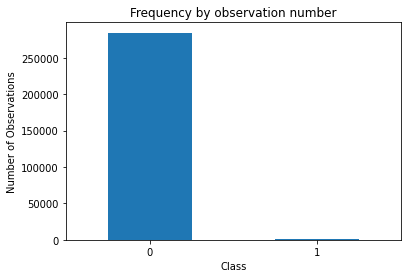

In [ ]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

**Visualizing the amount for normal and fraud transactions.**

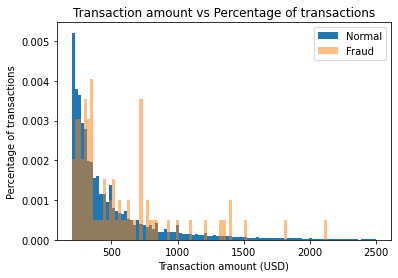

In [ ]:
# Save the normal and fradulent transactions in separate dataframe
normal_dataset = dataset[dataset.Class == 0] 
fraud_dataset = dataset[dataset.Class == 1]
#Visualize transactionamounts for normal and fraudulent transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction amount vs Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions");
plt.show()

**Create train and test dataset**

In [ ]:
sc=StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1, 1))

In [ ]:
raw_data = dataset.values
# The last element contains if the transaction is normal which is represented by a 0 and if fraud then 1
labels = raw_data[:, -1]
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=2021
)

**Normalize the data to have a value between 0 and 1**

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Normal data has a value of 0 in the target variable. Using the target variable to create a normal and fraud dataset.

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
#creating normal and fraud datasets
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]
print(" No. of records in Fraud Train Data=",len(fraud_train_data))
print(" No. of records in Normal Train data=",len(normal_train_data))
print(" No. of records in Fraud Test Data=",len(fraud_test_data))
print(" No. of records in Normal Test data=",len(normal_test_data))

 No. of records in Fraud Train Data= 389
 No. of records in Normal Train data= 227456
 No. of records in Fraud Test Data= 103
 No. of records in Normal Test data= 56859


**Set the training parameter values**

In [ ]:
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4  
learning_rate = 1e-7

**Create the Autoencoder**

In [ ]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",                                activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

**Define the callbacks for checkpoints and early stopping**

In [ ]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

**Compile the Autoencoder**

In [ ]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

**Train the Autoencoder**

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_data, test_data),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Epoch 1/50
3538/3554 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.0474
Epoch 1: val_loss improved from inf to 0.00122, saving model to autoencoder_fraud.h5
3554/3554 [==============================] - 12s 3ms/step - loss: 0.0050 - accuracy: 0.0475 - val_loss: 0.0012 - val_accuracy: 0.0363
Epoch 2/50
3546/3554 [============================>.] - ETA: 0s - loss: 1.9575e-05 - accuracy: 0.0679
Epoch 2: val_loss improved from 0.00122 to 0.00116, saving model to autoencoder_fraud.h5
3554/3554 [==============================] - 10s 3ms/step - loss: 1.9574e-05 - accuracy: 0.0680 - val_loss: 0.0012 - val_accuracy: 0.0363
Epoch 3/50
3543/3554 [============================>.] - ETA: 0s - loss: 1.9540e-05 - accuracy: 0.0628
Epoch 3: val_loss improved from 0.00116 to 0.00107, saving model to autoencoder_fraud.h5
3554/3554 [==============================] - 9s 3ms/step - loss: 1.9541e-05 - accuracy: 0.0628 - val_loss: 0.0011 - val_accuracy: 0.0363
Epoch 4/50
3546/3554 [====

**Plot training and test loss**

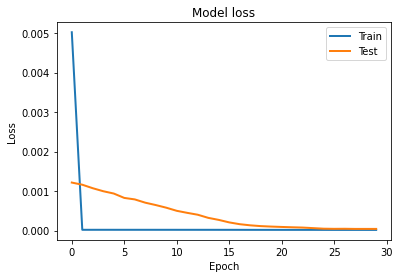

In [ ]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

**Detect Anomalies on test data**

In [ ]:
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})

1781/1781 [==============================] - 3s 1ms/step


Plotting the test data points and their respective reconstruction error sets a threshold value to visualize if the threshold value needs to be adjusted.

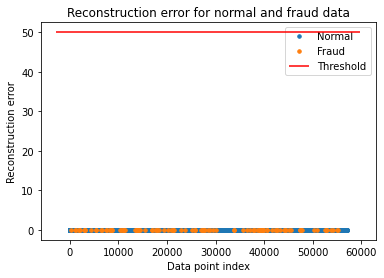

In [ ]:
threshold_fixed = 50
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Detect anomalies as points where the reconstruction loss is greater than a fixed threshold. Here we see that a value of 52 for the threshold will be good.

**Evaluating the performance of the anomaly detection**

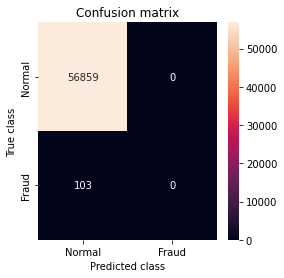

 Accuracy:  0.9981917769741231
 Recall:  0.0
 Precision:  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
threshold_fixed =52
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

As our dataset is highly imbalanced, we see a high accuracy but a low recall and precision.

Things to further improve precision and recall would add more relevant features, different architecture for autoencoder, different hyperparameters, or a different algorithm.

**Conclusion:**
Autoencoder can be used as an anomaly detection algorithm when we have an unbalanced dataset where we have a lot of good examples and only a few anomalies. Autoencoders are trained to minimize reconstruction error. When we train the autoencoders on normal data or good data, we can hypothesize that the anomalies will have higher reconstruction errors than the good or normal data.